# Decoding Cannabis Use from Structural and Diffusion MRI

### Features
sMRI features were derived from Mindboggle (Freesurfer + ANTs)

dMRI features were derived from TBSS+MELODIC (FSL)

### Feature Normalization
A GLM used to determine residuals, controlled for covariates. Residuals were subsequently used as features during training/testing.
    
$\hat{y} = \beta_{0} + \beta_{1}ICV + \beta_{2}Sex + \beta_{3}Age + \beta_{4}Site$

$\varepsilon = y - \hat{y}$ 

$residuals = \varepsilon$

### Feature Selection
An ANOVA was used to determine F-stastics and the top ${n}^{th}$ percentile
of F-statistics was during training/testing. 

The ${n}^{th}$ percentile was determined via gridsearch.

### SVM and DNN 
Nested, statified k-folds cross validation was used for both the SVM
and DNN classifier. 

SVM hyperparamters include cost (${C}$), gamma ($\gamma$), and kernel ($\kappa$). 

DNN hyperparameters inlcude initalizers, activation functions, batch size and weight decay. 

Both classifiers include ANOVA percentile as a hyperparameter.

DNN archtecture include two hidden layers, the number of nodes in these layers was determined following suggestions given by Huang (2003). The network had one output layer with a binary cross-entropy activation function, required for binary classification tasks.

Cross-validation, grid-search, and SVM was implemented using sci-kit learn (Pedregosa et al., 2011) and the DNN was implemented using Keras (Chollet, 2015).


### References
Chollet, F. (2015) Keras, GitHub. https://github.com/fchollet/keras.

Huang, G.B. (2003). Learning capability and storage capacity of two-hidden-layer feedforward networks. IEEE Transactions on Neural Networks, 14, 274–281. doi: 10.1109/TNN.2003.809401

Pedregosa F., Varoquaux, G., Gramfort, A., Michel V., Thirion, B.,  Grisel, O... Duchesnay, E. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research 12, 825-2830.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import re

import numpy as np
import pandas as pd

from cannabisml.stats import normalize, top_hundred, calc_performance, ANOVASelection
from cannabisml.models import create_model
from cannabisml.cv import train_test
from cannabisml.plts import plot_perfomance

Using TensorFlow backend.


In [3]:
# Load Data
base_dir = os.path.abspath('')

df_anat = pd.read_csv(base_dir + '/features_mb.csv', delimiter=',')
df_dmri = pd.read_csv(base_dir + '/features_dmri.csv', delimiter=',')
df_covar = pd.read_csv(base_dir + '/demographics.csv', delimiter=',')
df_covar['ICV'] = np.genfromtxt(base_dir + '/ICV.csv', delimiter=',', dtype=np.float_)

labels = df_covar.pop('Group')
labels = [1 if grp == 'Cannabis' else 0 for grp in labels]
labels = np.reshape(labels, (len(labels), 1))

# Remove component features from anatomical dataframe
rm_feats = [feat for feat in df_anat.columns if 'component' in feat]  
for feat in rm_feats:
    df_anat.drop(feat, axis=1, inplace=True)

# Remove frontomarginal features (all zeros) - issue with mindboggle
for feat in df_anat:
    if 'frontomarginal' in feat:
        df_anat.drop(feat, axis=1, inplace=True)
        
df_anat_head = list(df_anat.columns)
df_anat_head = [re.sub('/.*_', '_', lab) for lab in df_anat_head]
df_anat.columns = df_anat_head

In [4]:
df_covar.head()

Site     Sex  Age        ICV
0  MEG  Female   48  1137581.0
1  MEG  Female   40  1252070.0
2  MEG    Male   29  1331925.0
3  MEG  Female   55  1158175.0
4  MEG  Female   20  1067264.0

In [5]:
df_anat.head()

ctx_lh_unknown  ctx_lh_bankssts  ctx_lh_caudalanteriorcingulate  \
0           508.0           2415.0                          1278.0   
1           675.0           2183.0                          1452.0   
2           573.0           3171.0                          2723.0   
3           686.0           2145.0                          1765.0   
4           342.0           2179.0                          1743.0   

   ctx_lh_caudalmiddlefrontal  ctx_lh_cuneus  ctx_lh_entorhinal  \
0                    5814.000         3131.0             2543.0   
1                    7312.000         3637.0             2927.0   
2                    7888.000         5312.0             2318.0   
3                    6130.000         3281.0             2665.0   
4                    5651.999         3087.0             2896.0   

   ctx_lh_fusiform  ctx_lh_inferiorparietal  ctx_lh_inferiortemporal  \
0         9622.000                13228.000                11319.000   
1        10707.999                11010.999                11097.999   
2        10571.999                16982.999                16502.999   
3        10375.000                12448.000                11978.000   
4         7464.999                12828.998                12798.998   

   ctx_lh_isthmuscingulate  ...  \
0                   2553.0  ...   
1                   2874.0  ...   
2                   3910.0  ...   
3                   2555.0  ...   
4                   2445.0  ...   

   freesurfer_convexity_(sulc)_mean_left_1st_transverse_temporal_sulcus_and_Heschl_sulcus_left  \
0                                           0.323308                                             
1                                           0.170150                                             
2                                          -0.404052                                             
3                                          -0.260241                                             
4                                           0.897569                                             

   freesurfer_convexity_(sulc)_mean_left_cingulate_sulcus_left  \
0                                           2.489423             
1                                           2.072789             
2                                           2.078258             
3                                           2.242315             
4                                           2.327713             

   freesurfer_convexity_(sulc)_mean_left_paracentral_sulcus_left  \
0                                           0.402030               
1                                           0.139700               
2                                           1.213667               
3                                           1.600217               
4                                           0.423743               

   freesurfer_convexity_(sulc)_mean_left_parietooccipital_fissure_left  \
0                                           0.643527                     
1                                           0.988163                     
2                                           1.122116                     
3                                           0.815606                     
4                                           0.920232                     

   freesurfer_convexity_(sulc)_mean_left_calcarine_fissure_left  \
0                                           1.258196              
1                                           0.363485              
2                                          -0.050774              
3                                           1.296906              
4                                           0.859225              

   freesurfer_convexity_(sulc)_mean_left_superior_rostral_sulcus_left  \
0                                           1.994927                    
1                                           0.851566                    
2                                           1.190769                    


In [6]:
df_dmri.head()

AD_comp01  AD_comp02  AD_comp03  AD_comp04  AD_comp05  AD_comp06  \
0   1.559042  -1.031062   0.348992  -0.985278   0.454355  -1.079935   
1  -0.846423  -0.331397   0.034909  -0.310096   0.591088  -0.469001   
2  -0.490383  -0.843698  -1.428882  -1.057145   0.718603  -0.660883   
3   0.722853   0.413201  -0.113091  -0.897137  -0.381606  -1.205937   
4  -1.704244  -1.140562  -0.884692  -0.781600   1.056348   0.180644   

   AD_comp07  AD_comp08  AD_comp09  AD_comp10  ...  RD_comp19  RD_comp20  \
0   0.998655  -0.039297  -1.355619  -0.020012  ...   1.113301   0.217425   
1  -0.665607   0.186756  -0.710436  -0.881362  ...  -0.328963   0.238317   
2   1.521868  -0.651097  -0.457101  -0.019379  ...  -0.479662   0.056175   
3  -0.540756  -0.296770  -0.536705  -0.460994  ...  -0.645613   0.547728   
4   0.184508  -1.048740  -0.492706  -0.979327  ...   0.397924  -0.165874   

   RD_comp21  RD_comp22  RD_comp23  RD_comp24  RD_comp25  RD_comp26  \
0   1.220362   0.314041  -0.658188   0.382674   0.522208  -0.240596   
1  -1.255819  -0.278204  -0.312312  -0.249750  -0.117359  -0.167222   
2  -0.201937  -0.109117   0.048146  -0.157179  -0.052379   0.300105   
3  -0.585841   0.147987  -0.345887  -0.170019   0.110419  -0.039710   
4  -0.493489  -0.920369  -0.024156  -0.273278  -0.227234   0.248468   

   RD_comp27  RD_comp28  
0   0.584421  -0.540687  
1   0.112362   0.588930  
2  -0.425901  -0.183444  
3   0.075160  -0.324977  
4  -0.116304  -0.107905  

[5 rows x 112 columns]

In [7]:
# Features matrix shape
print('dMRI: ' + str(np.shape(df_dmri)))
print()
print('sMRI: ' + str(np.shape(df_anat)))

dMRI: (319, 112)

sMRI: (319, 923)


In [8]:
# Normalize data
df_anat_res, df_anat_uni, feature_names_anat = normalize(df_anat, df_covar)
df_dmri_res, df_dmri_uni, feature_names_dmri = normalize(df_dmri, df_covar)

In [9]:
def calc_proportion(df):
    sex_prop = np.sum(df['Sex'])/len(df['Sex'])
    site_prop = np.sum(df['Site'])/len(df['Site'])
    age_prop = np.sum(df['Age'])/len(df['Age'])
    icv_prop = np.sum(df['ICV'])/len(df['ICV'])
    print(f'Sex: {sex_prop}')
    print(f'Site: {site_prop}')
    print(f'Age: {age_prop}')
    print(f'ICV: {icv_prop}')

print(f'Proportion of dMRI features with significant covariate tests:')
calc_proportion(df_dmri_uni)
print()
print(f'Proportion of sMRI features with significant covariate tests:')
calc_proportion(df_anat_uni)

Proportion of dMRI features with significant covariate tests:
Sex: 0.26785714285714285
Site: 0.8125
Age: 0.44642857142857145
ICV: 0.25892857142857145

Proportion of sMRI features with significant covariate tests:
Sex: 0.6132177681473456
Site: 0.27735644637053086
Age: 0.6988082340195017
ICV: 0.8049837486457205


In [10]:
# Convert dataframe to np array
anat_res_arr = df_anat_res.values
dmri_res_arr = df_dmri_res.values

In [11]:
# DNN, dMRI
df_rates_dnn_dmri, tp_dnn_dmri, tn_dnn_dmri, fp_dnn_dmri, fn_dnn_dmri, top_feats_dnn_dmri, \
    y_test_dnn_dmri, probas_dnn_dmri = train_test('DNN', dmri_res_arr, labels, feature_names_dmri)

Fold 1
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10


In [12]:
df_rates_dnn_dmri

Optimizer     Initializer         Decay Batch Size Activation 1  \
Fold 1        SGD  glorot_uniform  1.000000e-07         64         relu   
Fold 2        SGD  glorot_uniform  1.000000e-03        128         relu   
Fold 3        SGD  glorot_uniform  1.000000e-03         32         relu   
Fold 4        SGD  glorot_uniform  1.000000e-07        256         relu   
Fold 5        SGD  glorot_uniform  1.000000e-09        256         relu   
Fold 6        SGD  glorot_uniform  1.000000e-07        128         relu   
Fold 7        SGD   glorot_normal  1.000000e-03         64         relu   
Fold 8        SGD   glorot_normal  1.000000e-03        256      sigmoid   
Fold 9        SGD  glorot_uniform  1.000000e-09        128         relu   
Fold 10       SGD   glorot_normal  1.000000e-03         64         tanh   

        Activation 2 Percentile  Sensitivity  Specificity       PPV       NPV  
Fold 1          tanh         80     0.750000     0.500000  0.714286  0.545455  
Fold 2          relu         80     0.800000     0.583333  0.761905  0.636364  
Fold 3       sigmoid         40     0.700000     0.500000  0.700000  0.500000  
Fold 4          relu         80     0.950000     0.500000  0.760000  0.857143  
Fold 5       sigmoid         60     0.750000     0.583333  0.750000  0.583333  
Fold 6       sigmoid         60     0.750000     0.666667  0.789474  0.615385  
Fold 7          tanh         60     0.600000     0.666667  0.750000  0.500000  
Fold 8       sigmoid         60     0.800000     0.750000  0.842105  0.692308  
Fold 9       sigmoid         60     0.700000     0.500000  0.700000  0.500000  
Fold 10      sigmoid         20     0.473684     0.666667  0.692308  0.444444

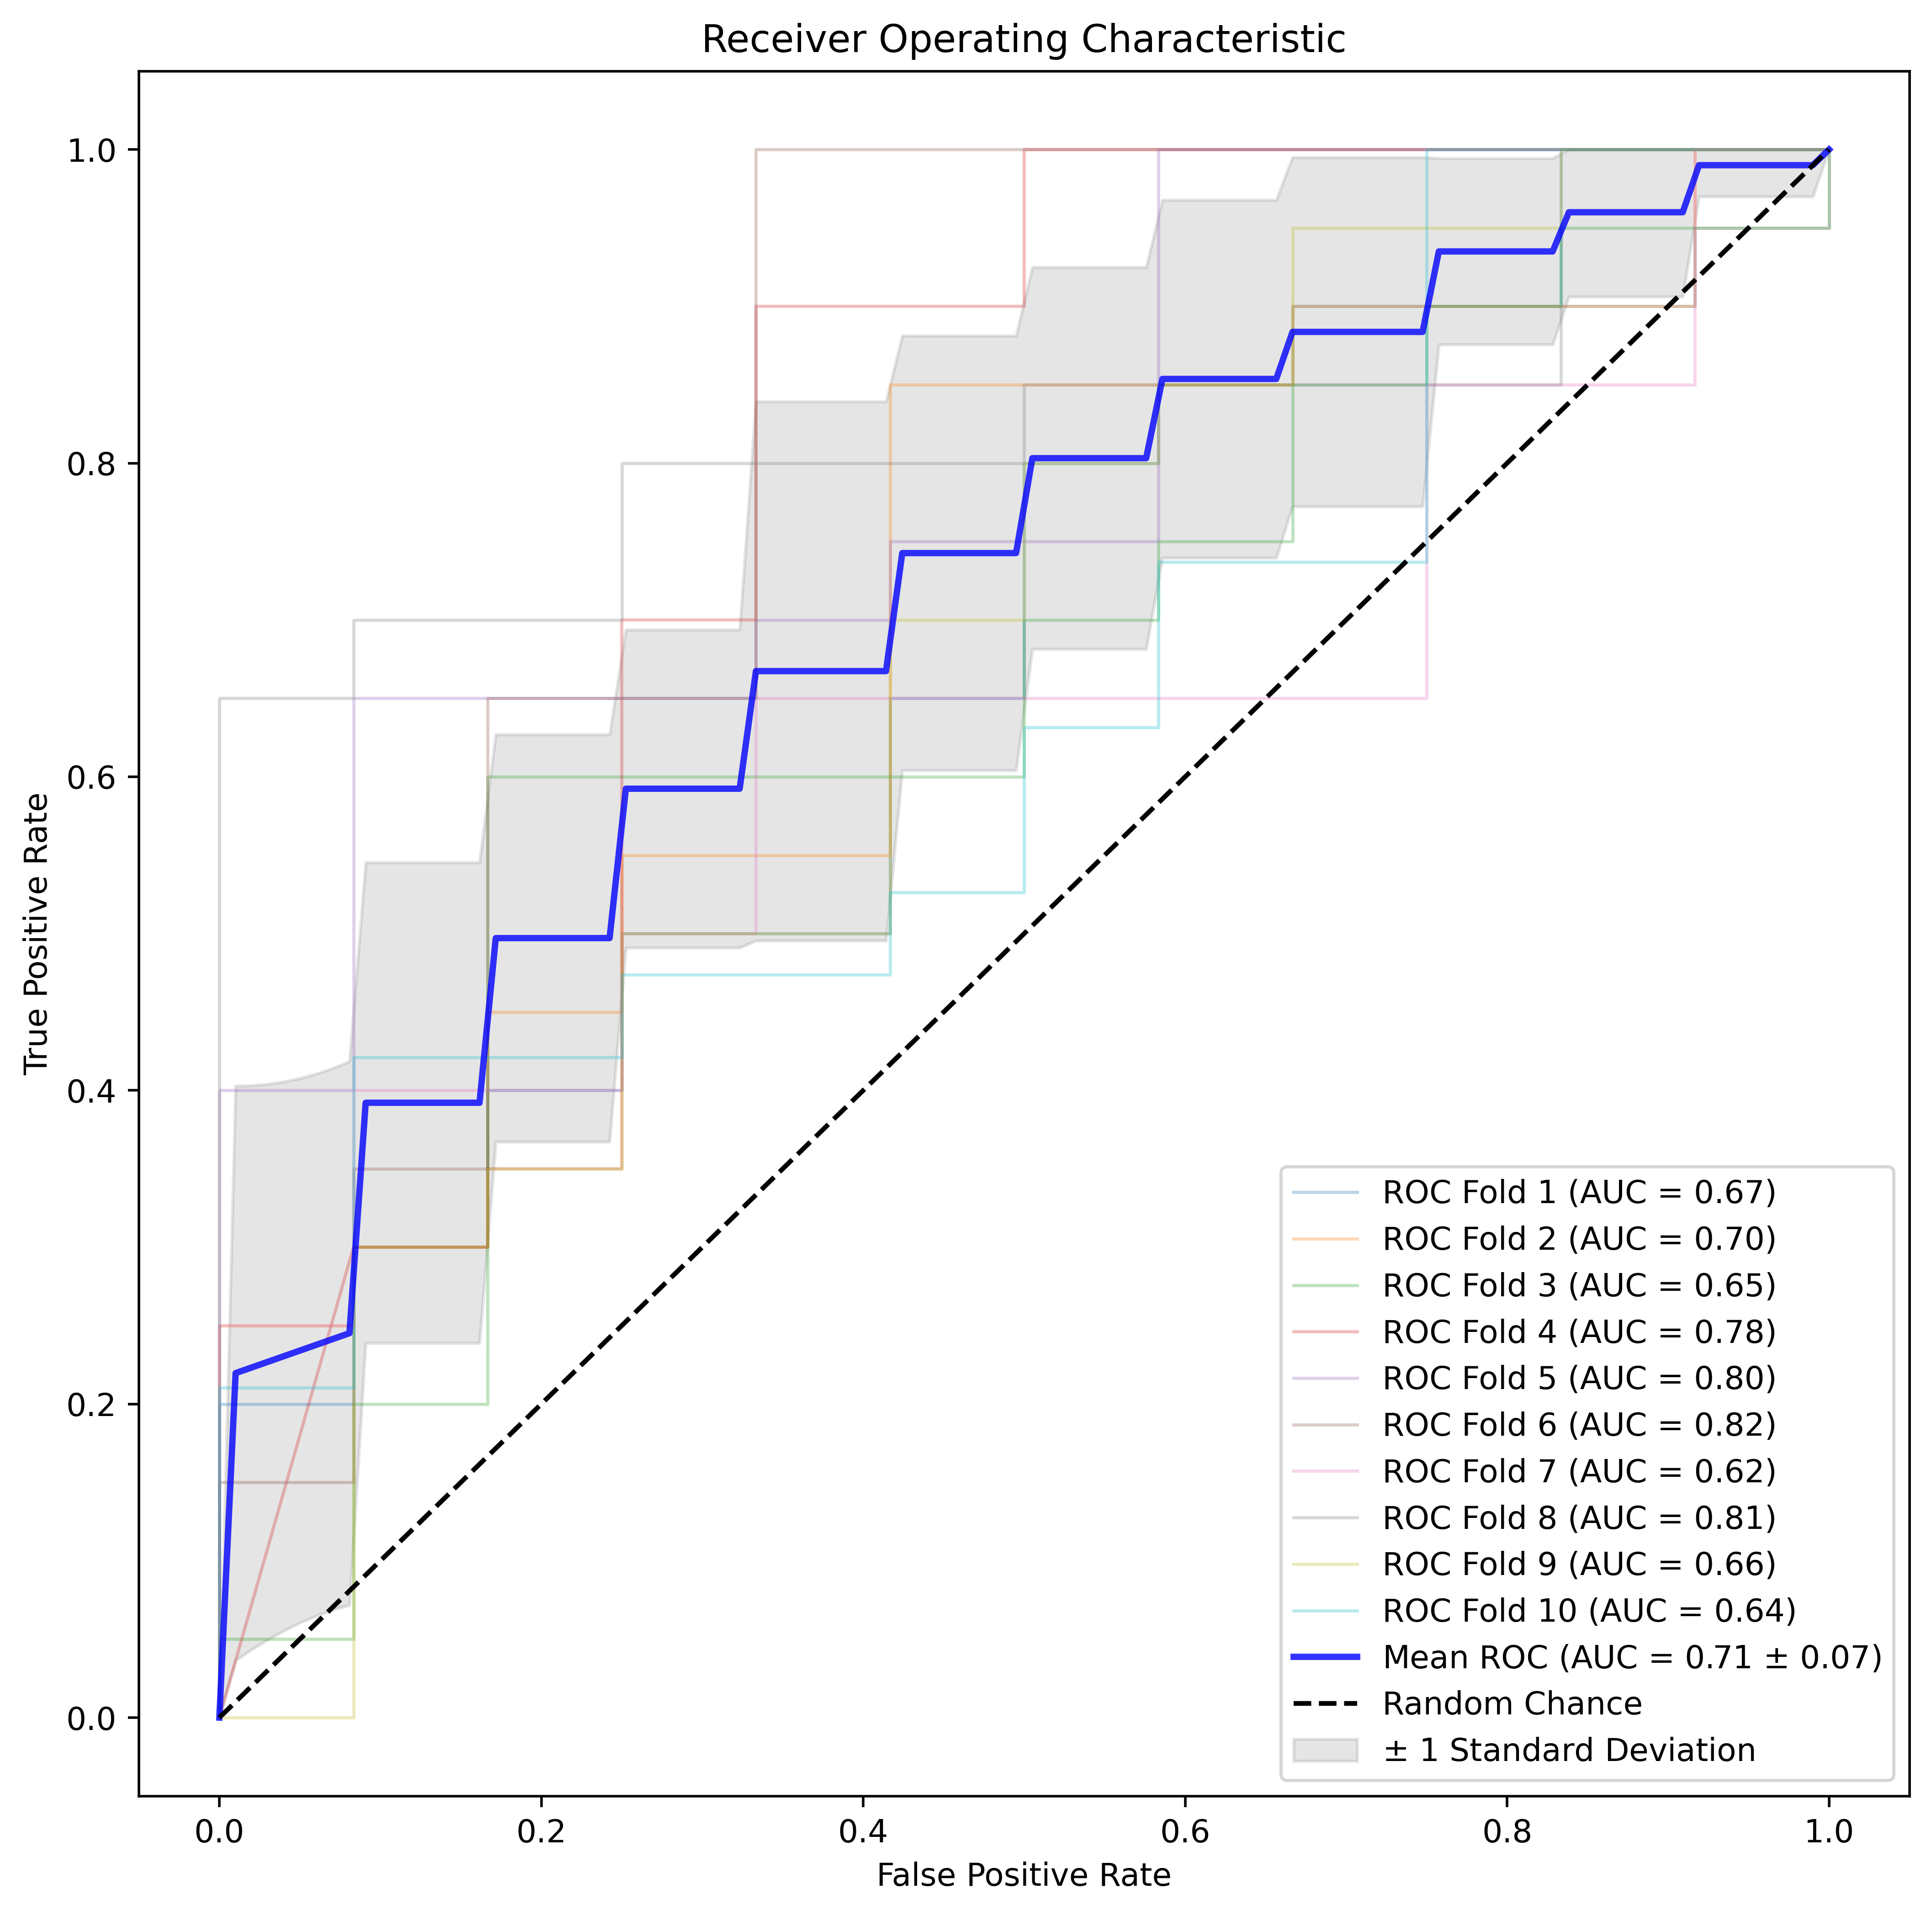

In [13]:
plot_perfomance(probas_dnn_dmri, y_test_dnn_dmri)

In [14]:
# DNN, sMRI
df_rates_dnn_anat, tp_dnn_anat, tn_dnn_anat, fp_dnn_anat, fn_dnn_anat, top_feats_dnn_anat, \
    y_test_dnn_anat, probas_dnn_anat = train_test('DNN', anat_res_arr, labels, feature_names_anat)

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10


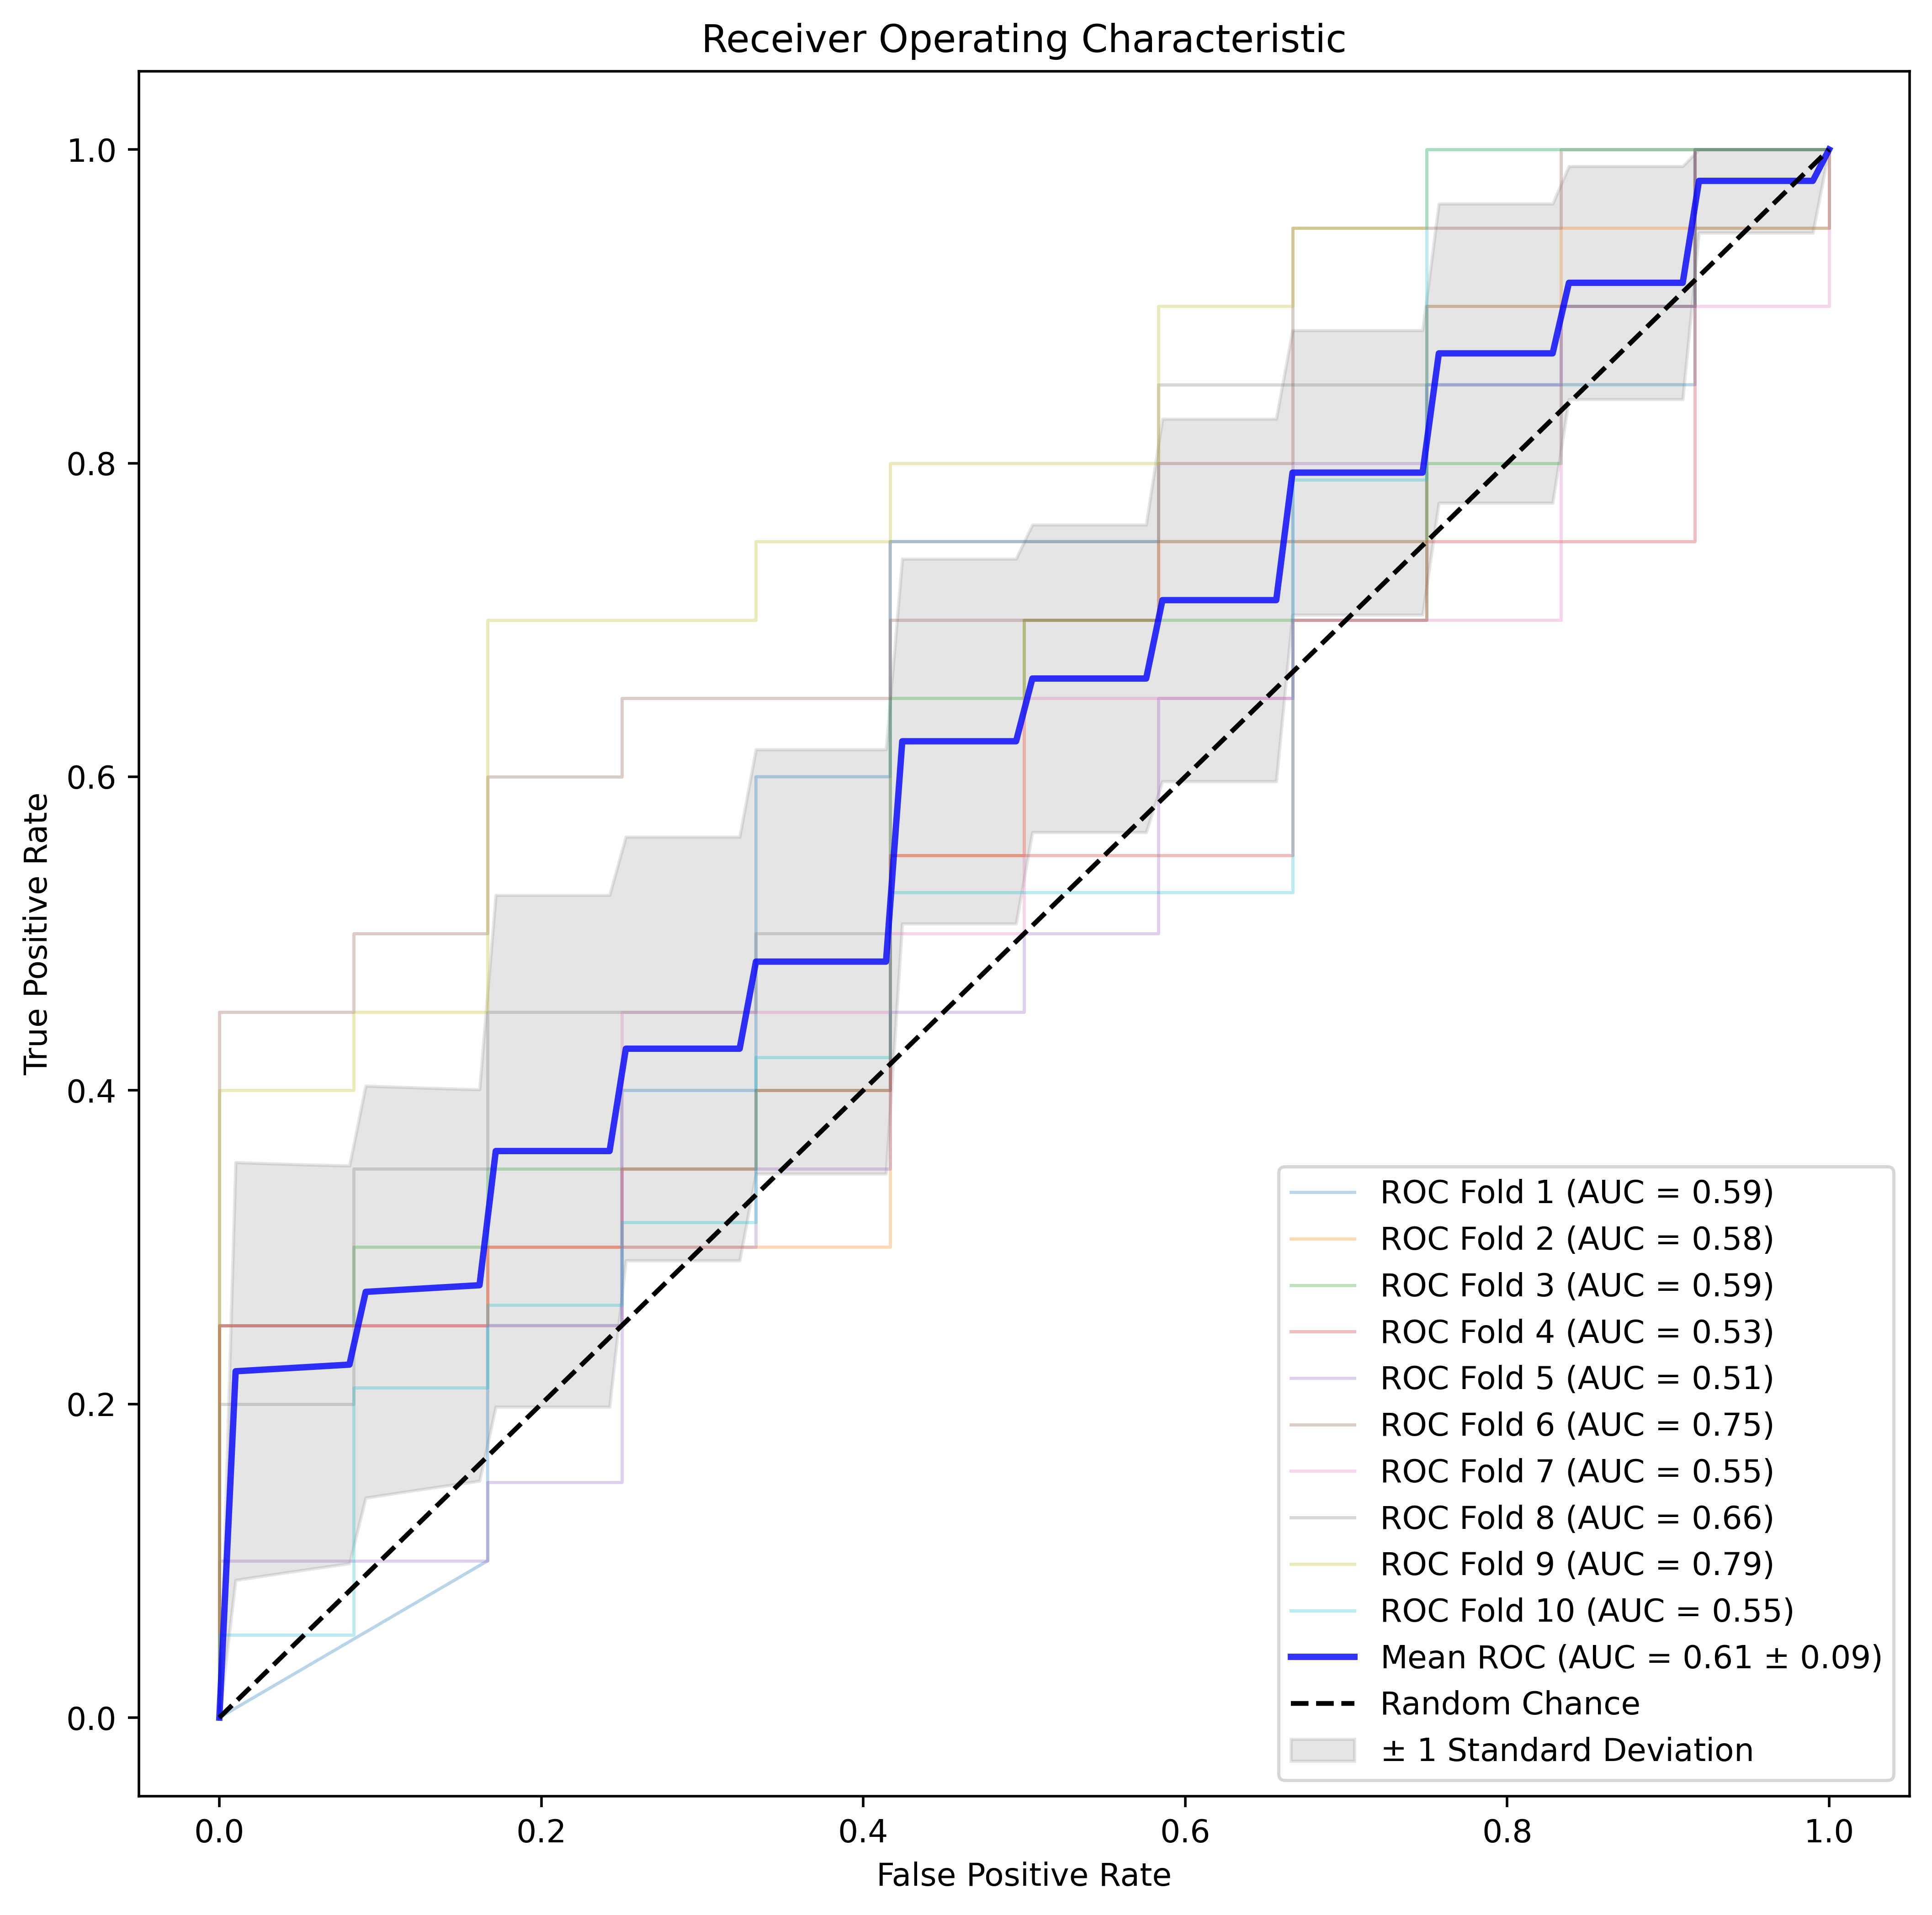

In [15]:
plot_perfomance(probas_dnn_anat, y_test_dnn_anat)

In [16]:
df_rates_dnn_anat

Optimizer     Initializer         Decay Batch Size Activation 1  \
Fold 1        SGD  glorot_uniform  1.000000e-07         32         relu   
Fold 2        SGD  glorot_uniform  1.000000e-07         64         relu   
Fold 3        SGD  glorot_uniform  1.000000e-09        256         tanh   
Fold 4        SGD   glorot_normal  1.000000e-07         64         tanh   
Fold 5        SGD   glorot_normal  1.000000e-07        256         tanh   
Fold 6        SGD   glorot_normal  1.000000e-03         32         tanh   
Fold 7        SGD   glorot_normal  1.000000e-07        128         tanh   
Fold 8        SGD  glorot_uniform  1.000000e-09         32         tanh   
Fold 9        SGD  glorot_uniform  1.000000e-07        256         relu   
Fold 10       SGD   glorot_normal  1.000000e-07         32         relu   

        Activation 2 Percentile  Sensitivity  Specificity       PPV       NPV  
Fold 1          relu         80     0.750000     0.333333  0.652174  0.444444  
Fold 2          tanh         40     0.700000     0.416667  0.666667  0.454545  
Fold 3          relu         80     0.700000     0.333333  0.636364  0.400000  
Fold 4          tanh         40     0.600000     0.333333  0.600000  0.333333  
Fold 5          relu         60     0.600000     0.416667  0.631579  0.384615  
Fold 6          relu         20     0.650000     0.583333  0.722222  0.500000  
Fold 7          relu         80     0.600000     0.500000  0.666667  0.428571  
Fold 8          relu         80     0.800000     0.416667  0.695652  0.555556  
Fold 9       sigmoid         40     0.800000     0.583333  0.761905  0.636364  
Fold 10      sigmoid         40     0.526316     0.583333  0.666667  0.437500

In [17]:
# SVM, dMRI
df_rates_svm_dmri, tp_svm_dmri, tn_svm_dmri, fp_svm_dmri, fn_svm_dmri, top_feats_svm_dmri, \
    y_test_svm_dmri, probas_svm_dmri = train_test('SVM', dmri_res_arr, labels, feature_names_dmri)

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10


In [18]:
df_rates_svm_dmri

Kernel     Gamma   Cost Percentile  Sensitivity  Specificity  \
Fold 1     rbf  0.031250      1         60     0.750000     0.583333   
Fold 2     rbf  0.007812   0.25         80     0.750000     0.500000   
Fold 3     rbf  0.007812   0.25         80     0.700000     0.666667   
Fold 4     rbf  0.007812   0.25         80     0.650000     0.500000   
Fold 5     rbf  0.031250    0.5         60     0.850000     0.750000   
Fold 6     rbf  0.031250    0.5         60     0.900000     0.666667   
Fold 7     rbf  0.007812      2         80     0.600000     0.583333   
Fold 8     rbf  0.003906     64         40     0.800000     0.583333   
Fold 9     rbf  0.015625  0.125         60     0.650000     0.583333   
Fold 10    rbf  0.015625    0.5         80     0.684211     0.833333   

              PPV       NPV  
Fold 1   0.750000  0.583333  
Fold 2   0.714286  0.545455  
Fold 3   0.777778  0.571429  
Fold 4   0.684211  0.461538  
Fold 5   0.850000  0.750000  
Fold 6   0.818182  0.800000  
Fold 7   0.705882  0.466667  
Fold 8   0.761905  0.636364  
Fold 9   0.722222  0.500000  
Fold 10  0.866667  0.625000

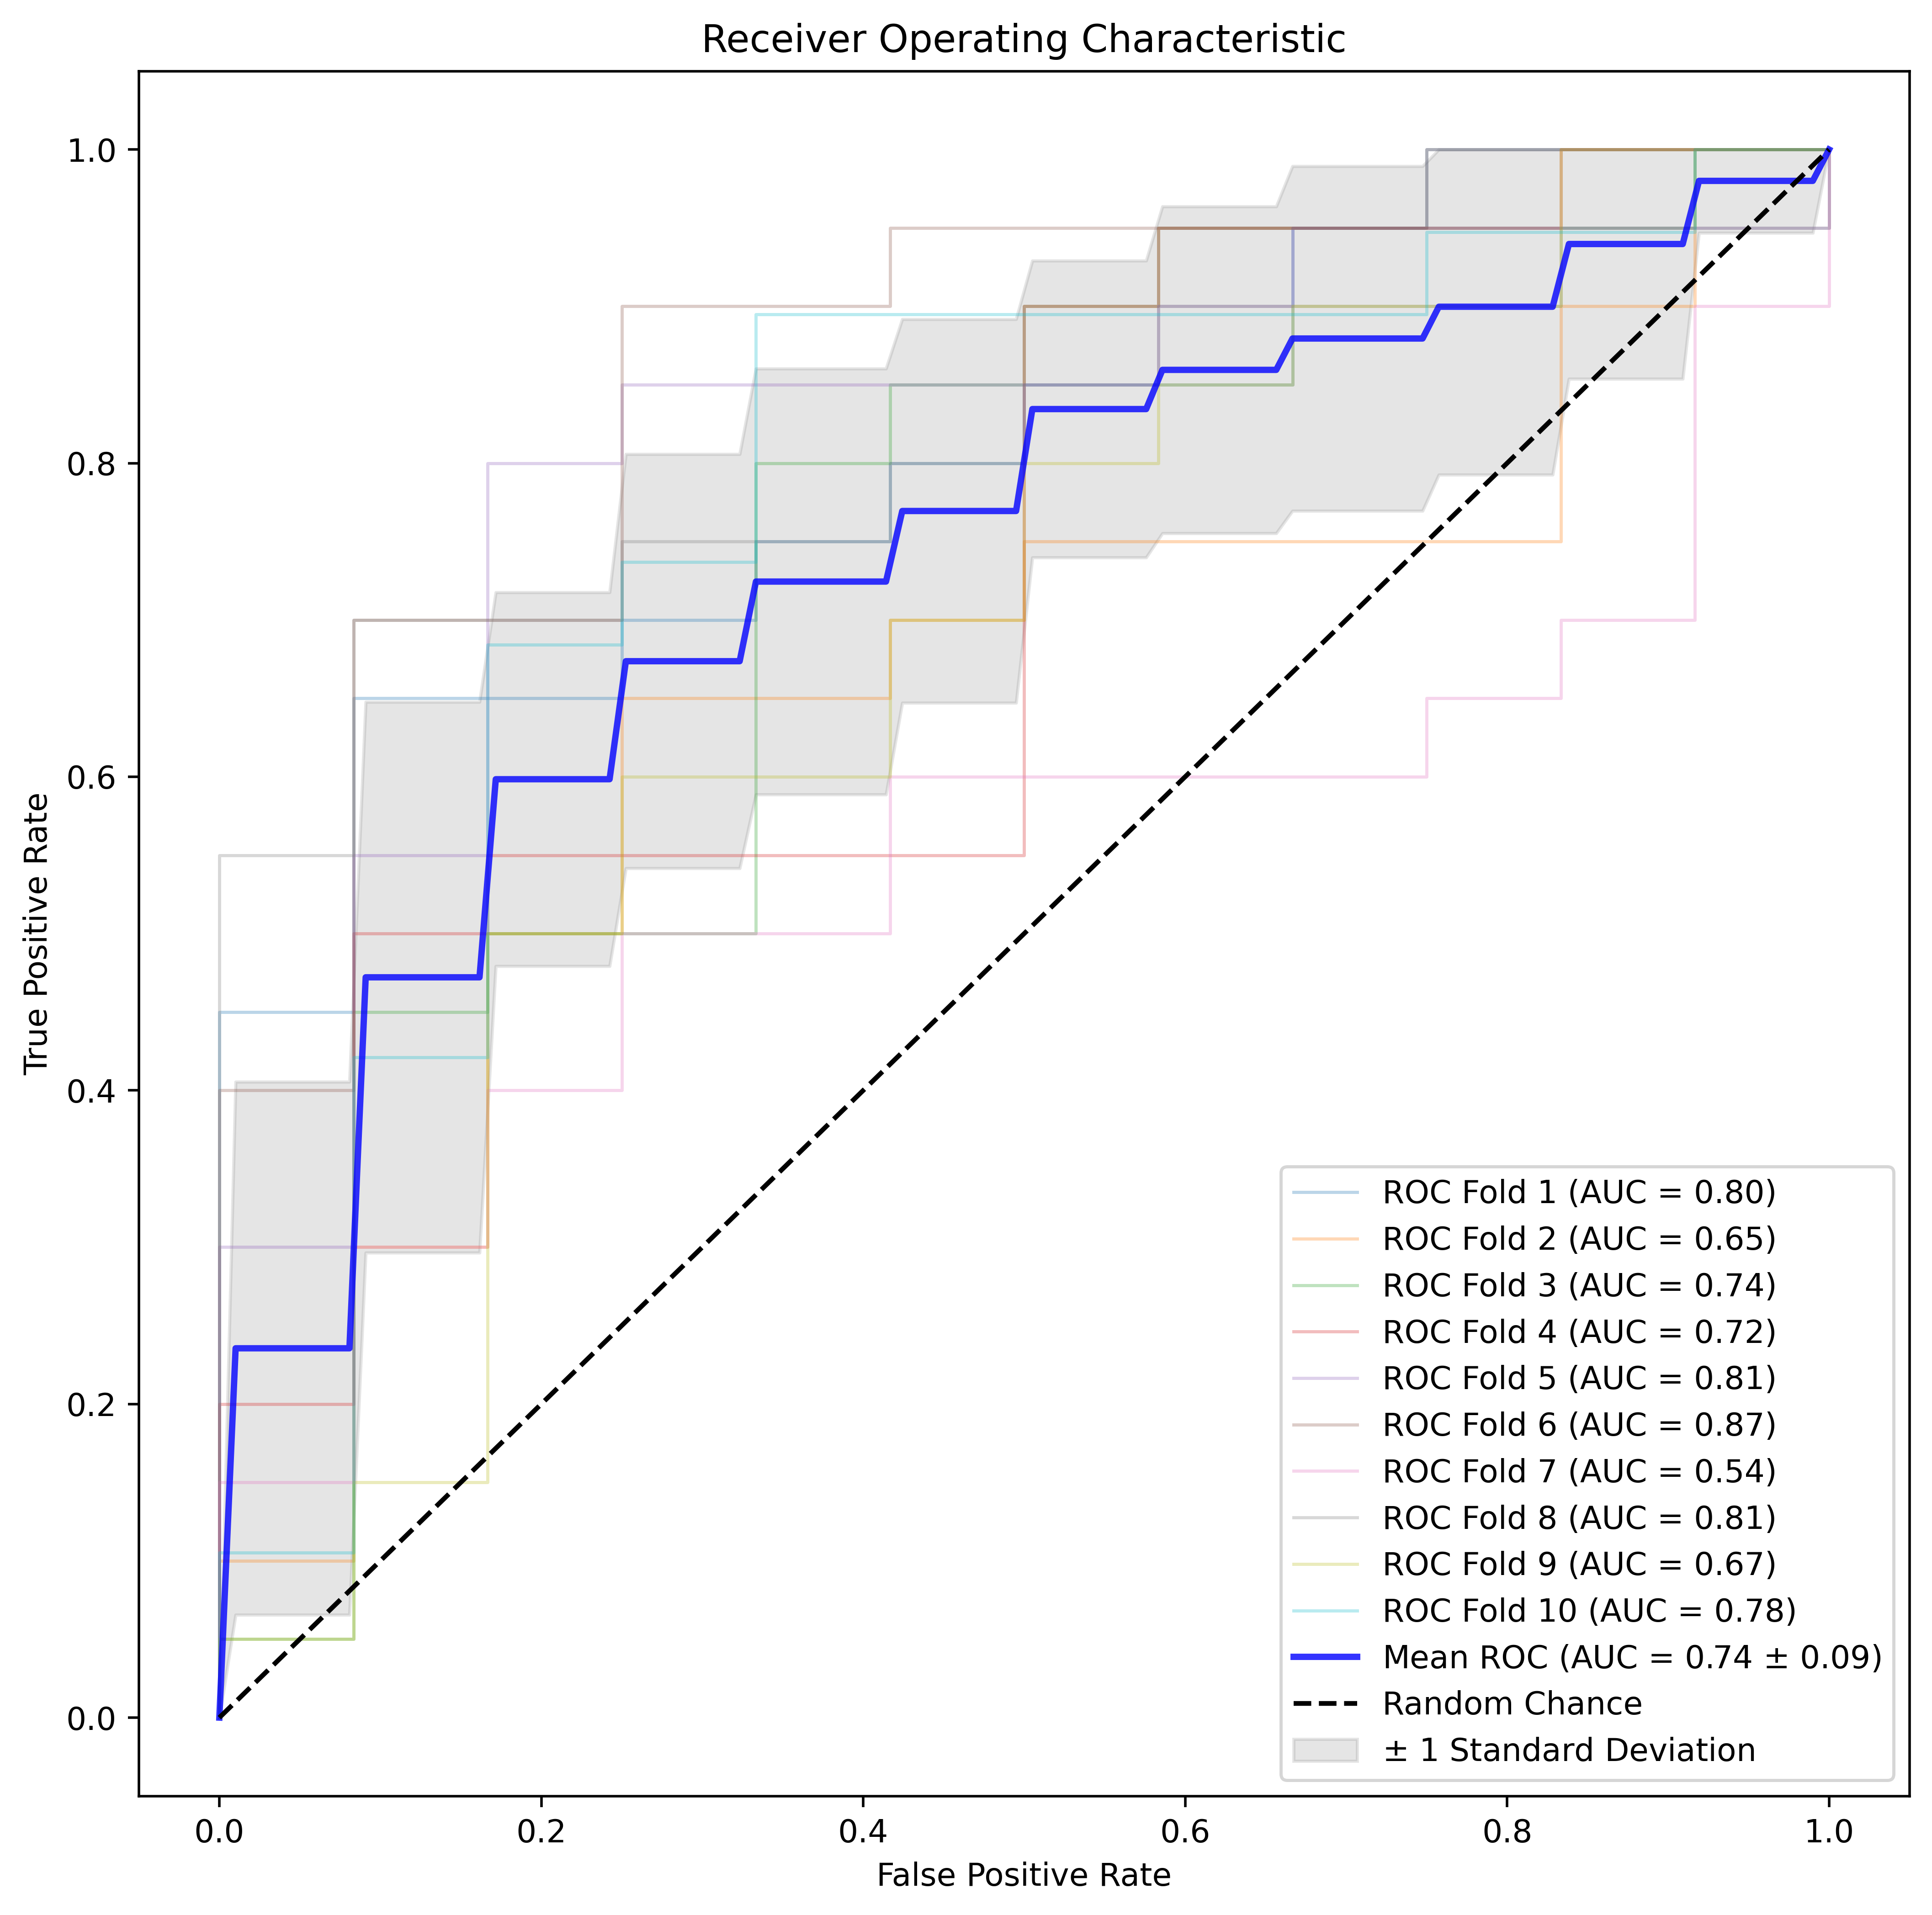

In [19]:
plot_perfomance(probas_svm_dmri, y_test_svm_dmri)

In [20]:
# SVM, sMRI
df_rates_svm_anat, tp_svm_anat, tn_svm_anat, fp_svm_anat, fn_svm_anat, top_feats_svm_anat, \
    y_test_svm_anat, probas_svm_anat = train_test('SVM', anat_res_arr, labels, feature_names_anat)

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10


In [21]:
df_rates_svm_anat

Kernel     Gamma     Cost Percentile  Sensitivity  Specificity  \
Fold 1   sigmoid  0.125000       16         20     0.450000     0.666667   
Fold 2   sigmoid  0.062500   0.0625         40     0.650000     0.500000   
Fold 3       rbf  0.000488        1         20     0.650000     0.416667   
Fold 4   sigmoid  4.000000   0.0625         40     0.650000     0.416667   
Fold 5   sigmoid  2.000000  0.03125         20     0.550000     0.583333   
Fold 6       rbf  0.007812     0.25         20     0.550000     0.833333   
Fold 7   sigmoid  1.000000   0.0625         60     0.750000     0.583333   
Fold 8   sigmoid  0.003906     0.25         20     0.600000     0.416667   
Fold 9   sigmoid  1.000000     0.25         20     0.600000     0.583333   
Fold 10      rbf  0.000977      0.5         80     0.473684     0.833333   

              PPV       NPV  
Fold 1   0.692308  0.421053  
Fold 2   0.684211  0.461538  
Fold 3   0.650000  0.416667  
Fold 4   0.650000  0.416667  
Fold 5   0.687500  0.437500  
Fold 6   0.846154  0.526316  
Fold 7   0.750000  0.583333  
Fold 8   0.631579  0.384615  
Fold 9   0.705882  0.466667  
Fold 10  0.818182  0.500000

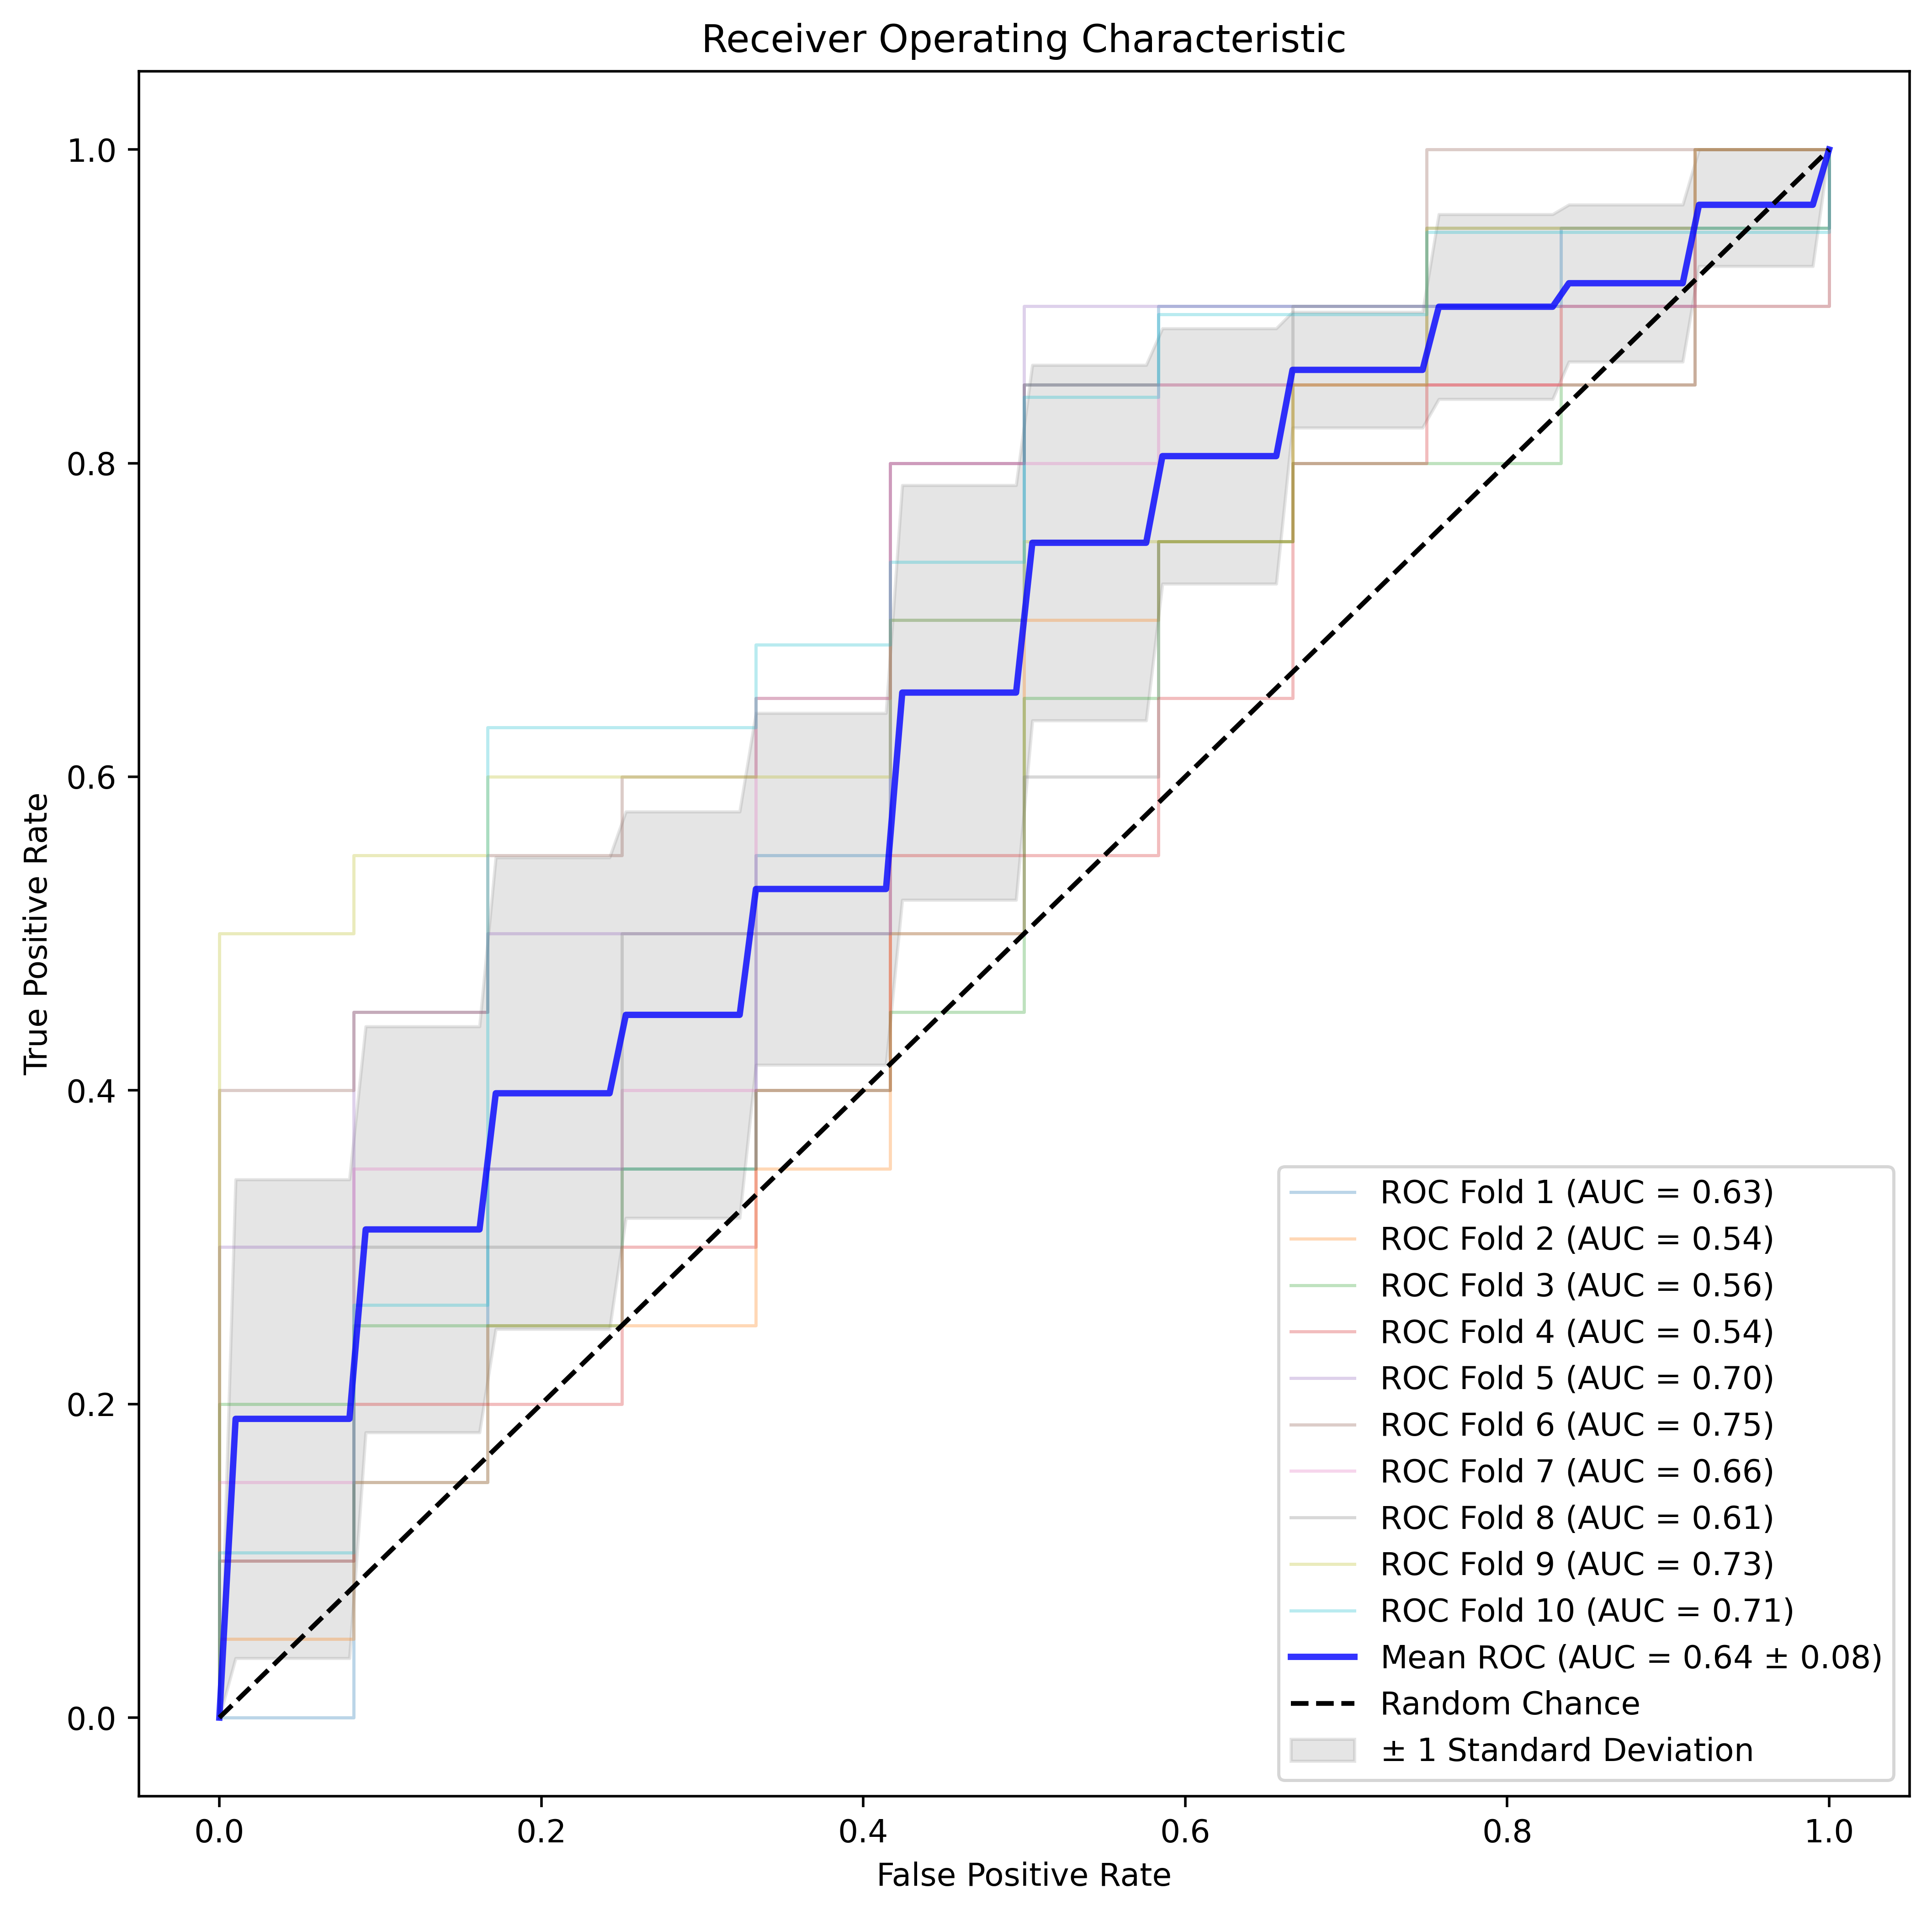

In [22]:
plot_perfomance(probas_svm_anat, y_test_svm_anat)

## Combined Features
The cells below combine dmri and smri features. The top 100 features, based on F-statistics, are selected for each feature set, independently, and then combined in an array of shape (n_subjects, 200). This decision was made due to imbalance in feature set size (923 sMRI features versus 112 dMRI features), allowing both feature sets to be equally represented during training and testing. Following this, the same train_test procedure as above is executed.

In [24]:
# Merge feature names
feature_names = np.concatenate([feature_names_dmri, feature_names_anat])

# Select top 100 features from each set and concat arrays
dmri_feats_top = top_hundred(dmri_res_arr, feature_names_dmri, labels)
anat_feats_top = top_hundred(anat_res_arr, feature_names_anat, labels)
df_dmri_top = df_dmri_res[dmri_feats_top]
df_anat_top = df_anat_res[anat_feats_top]
dmri_top_res_arr = df_dmri_top .values
anat_top_res_arr = df_anat_top.values
top_res_arr = np.concatenate([dmri_top_res_arr, anat_top_res_arr], axis=1)

In [25]:
df_rates_dnn_comb, tp_dnn_comb, tn_dnn_comb, fp_dnn_comb, fn_dnn_comb, top_feats_dnn_anat, y_test_dnn_comb, \
    probas_dnn_comb = train_test('DNN', top_res_arr, labels, feature_names)

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10


In [26]:
df_rates_dnn_comb

Optimizer     Initializer         Decay Batch Size Activation 1  \
Fold 1        SGD  glorot_uniform  1.000000e-05        256         relu   
Fold 2        SGD   glorot_normal  1.000000e-09         64         tanh   
Fold 3        SGD  glorot_uniform  1.000000e-09         64         tanh   
Fold 4        SGD   glorot_normal  1.000000e-09        256         relu   
Fold 5        SGD   glorot_normal  1.000000e-05         64         tanh   
Fold 6        SGD   glorot_normal  1.000000e-05         32         relu   
Fold 7        SGD   glorot_normal  1.000000e-05         32         relu   
Fold 8        SGD  glorot_uniform  1.000000e-07        256         relu   
Fold 9        SGD   glorot_normal  1.000000e-05        256         relu   
Fold 10       SGD   glorot_normal  1.000000e-03         64      sigmoid   

        Activation 2 Percentile  Sensitivity  Specificity       PPV       NPV  
Fold 1          relu         80     0.650000     0.666667  0.764706  0.533333  
Fold 2          relu         80     0.550000     0.333333  0.578947  0.307692  
Fold 3          relu         80     0.750000     0.500000  0.714286  0.545455  
Fold 4          relu         60     0.750000     0.250000  0.625000  0.375000  
Fold 5       sigmoid         80     0.600000     0.666667  0.750000  0.500000  
Fold 6          relu         60     0.750000     0.750000  0.833333  0.642857  
Fold 7          tanh         60     0.600000     0.583333  0.705882  0.466667  
Fold 8          relu         80     0.850000     0.416667  0.708333  0.625000  
Fold 9          relu         60     0.750000     0.583333  0.750000  0.583333  
Fold 10      sigmoid         40     0.631579     0.500000  0.666667  0.461538

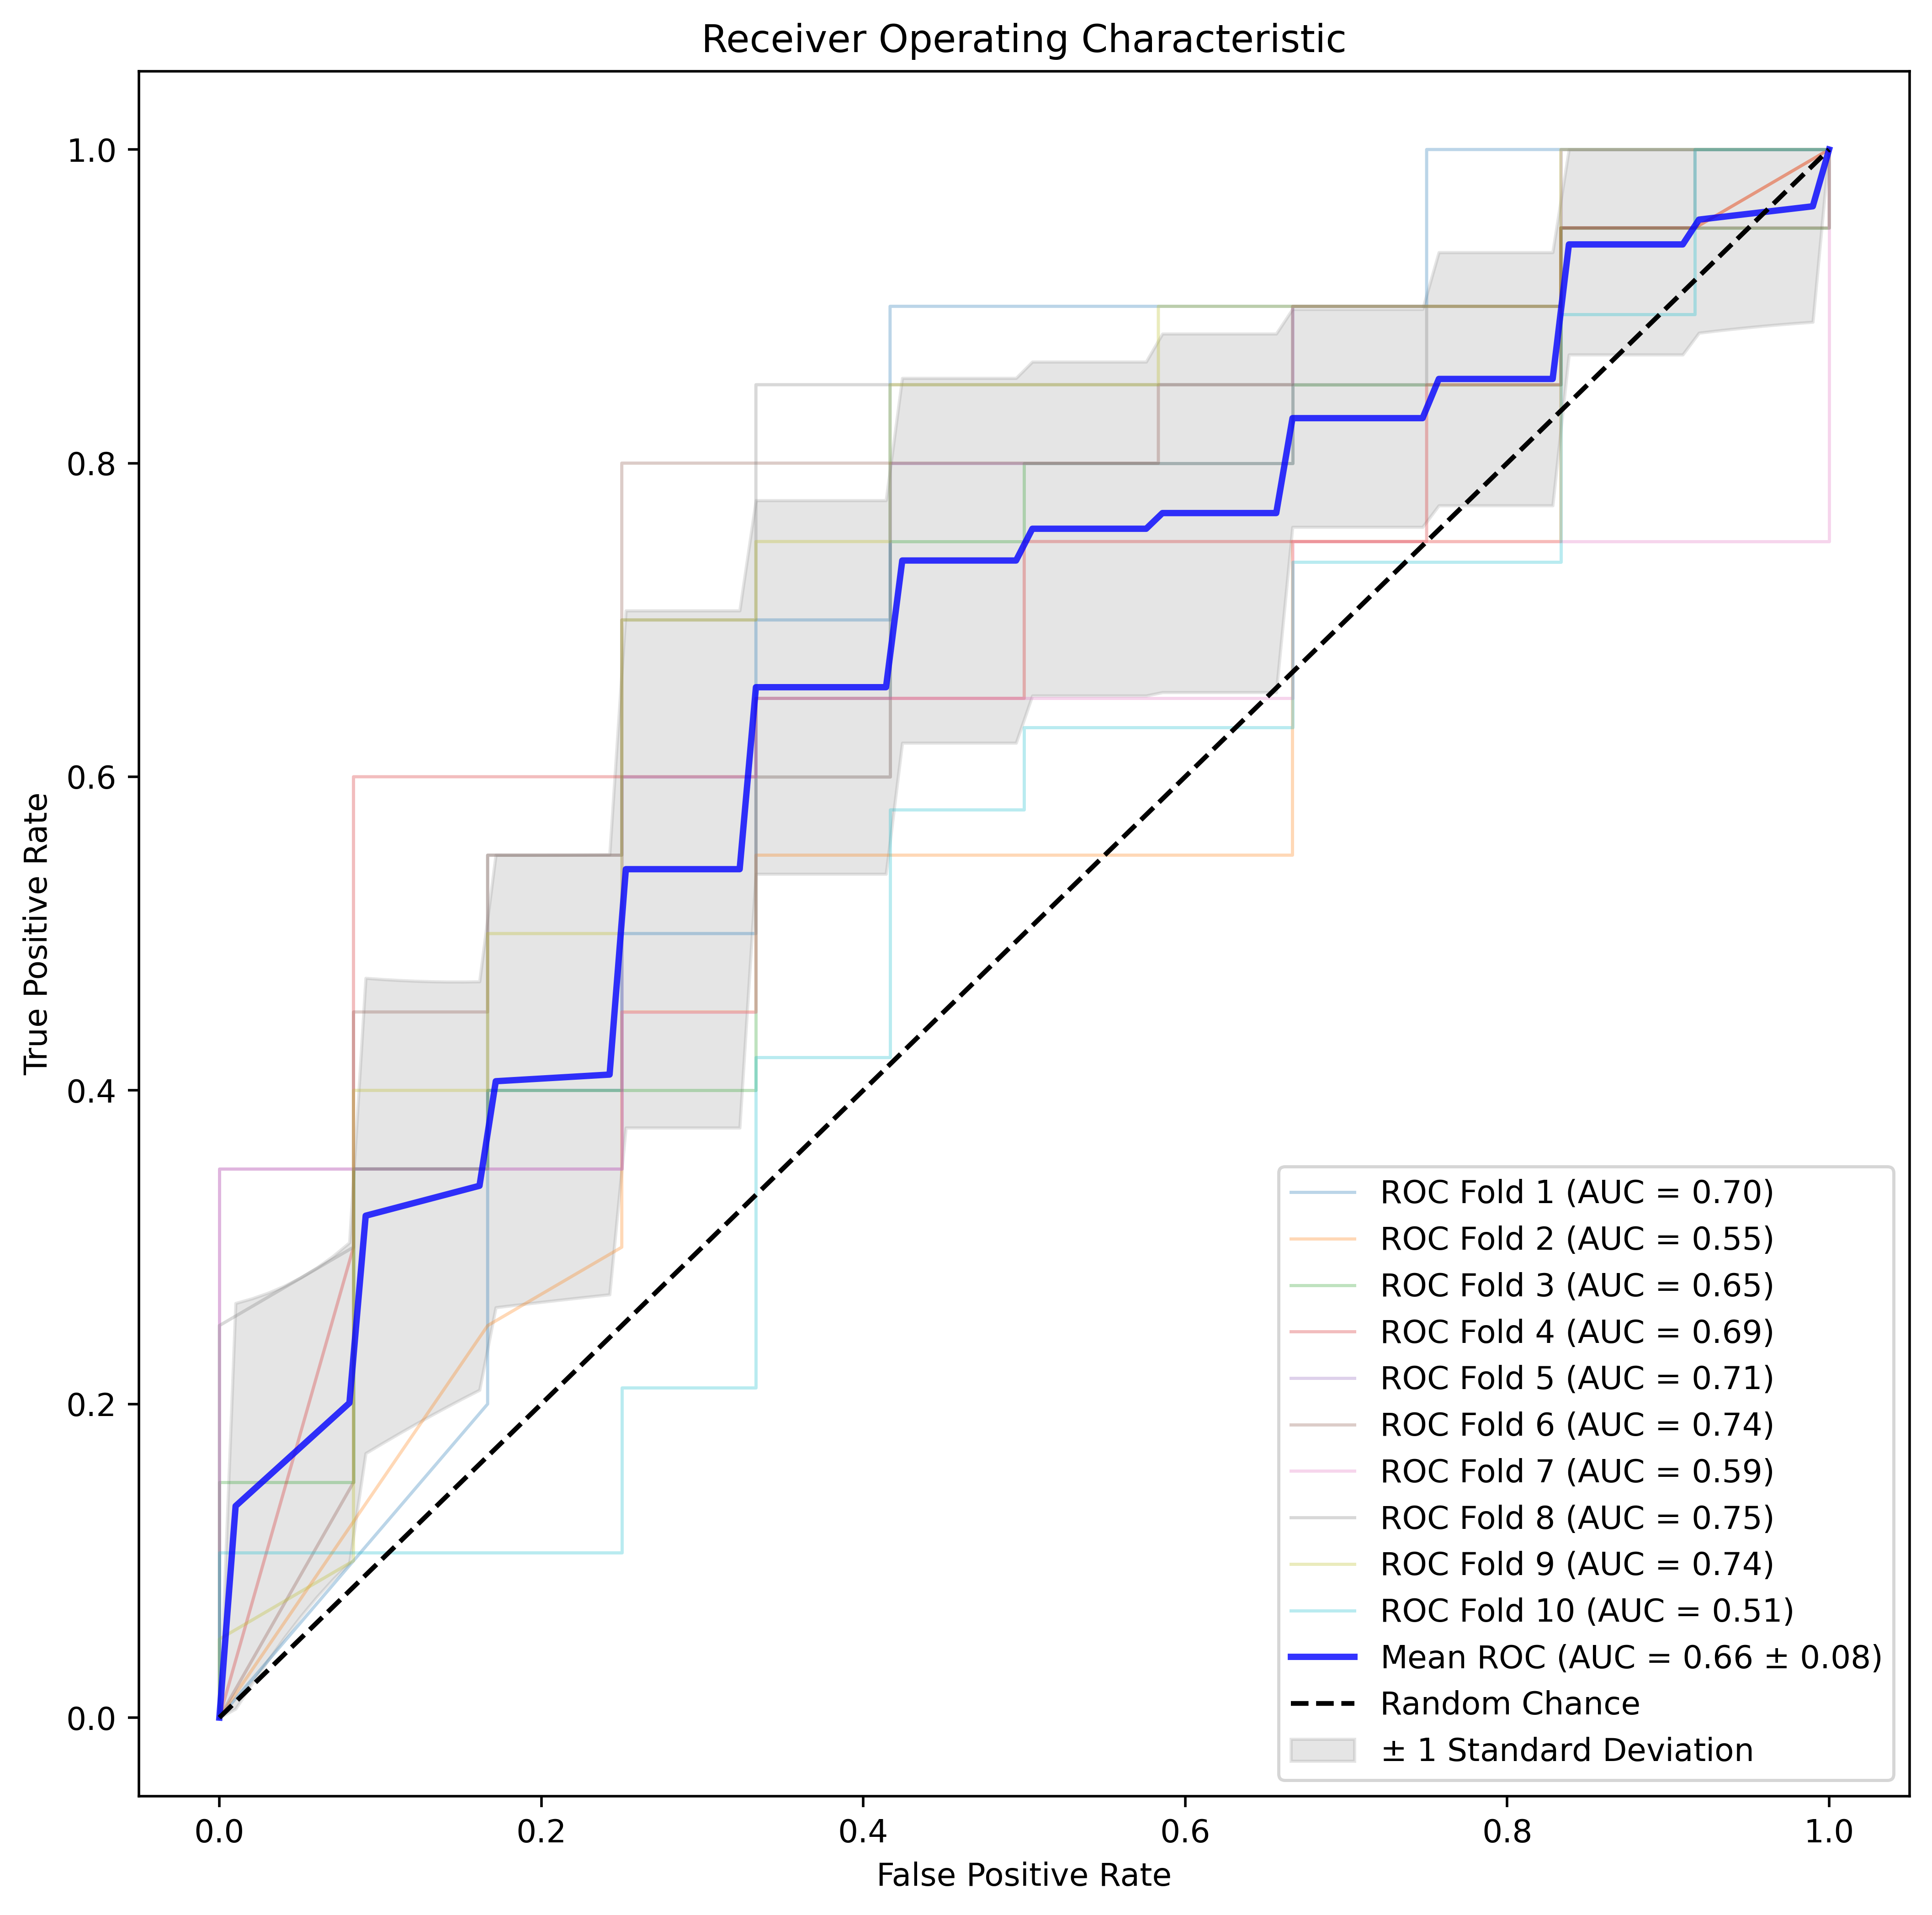

In [27]:
plot_perfomance(probas_dnn_comb, y_test_dnn_comb)

In [28]:
# SVM, combined
df_rates_svm_comb, tp_svm_comb, tn_svm_comb, fp_svm_comb, fn_svm_comb, top_feats_svm_anat, y_test_svm_comb, \
    probas_svm_comb = train_test('SVM', top_res_arr, labels, feature_names)

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10


In [29]:
df_rates_svm_comb

Kernel     Gamma    Cost Percentile  Sensitivity  Specificity  \
Fold 1   sigmoid  0.007812  0.1250         60     0.550000     0.666667   
Fold 2   sigmoid  0.031250  0.0625         80     0.600000     0.583333   
Fold 3       rbf  0.000122  2.0000         80     0.650000     0.750000   
Fold 4       rbf  0.007812  0.2500         60     0.700000     0.666667   
Fold 5   sigmoid  0.125000  0.0625         80     0.550000     0.666667   
Fold 6   sigmoid  0.031250  0.0625         60     0.700000     0.916667   
Fold 7       rbf  0.001953  0.5000         80     0.550000     0.666667   
Fold 8   sigmoid  0.031250  0.1250         60     0.800000     0.833333   
Fold 9       rbf  0.000977  1.0000         60     0.750000     0.916667   
Fold 10      rbf  0.007812  1.0000         80     0.473684     0.916667   

              PPV       NPV  
Fold 1   0.733333  0.470588  
Fold 2   0.705882  0.466667  
Fold 3   0.812500  0.562500  
Fold 4   0.777778  0.571429  
Fold 5   0.733333  0.470588  
Fold 6   0.933333  0.647059  
Fold 7   0.733333  0.470588  
Fold 8   0.888889  0.714286  
Fold 9   0.937500  0.687500  
Fold 10  0.900000  0.523810

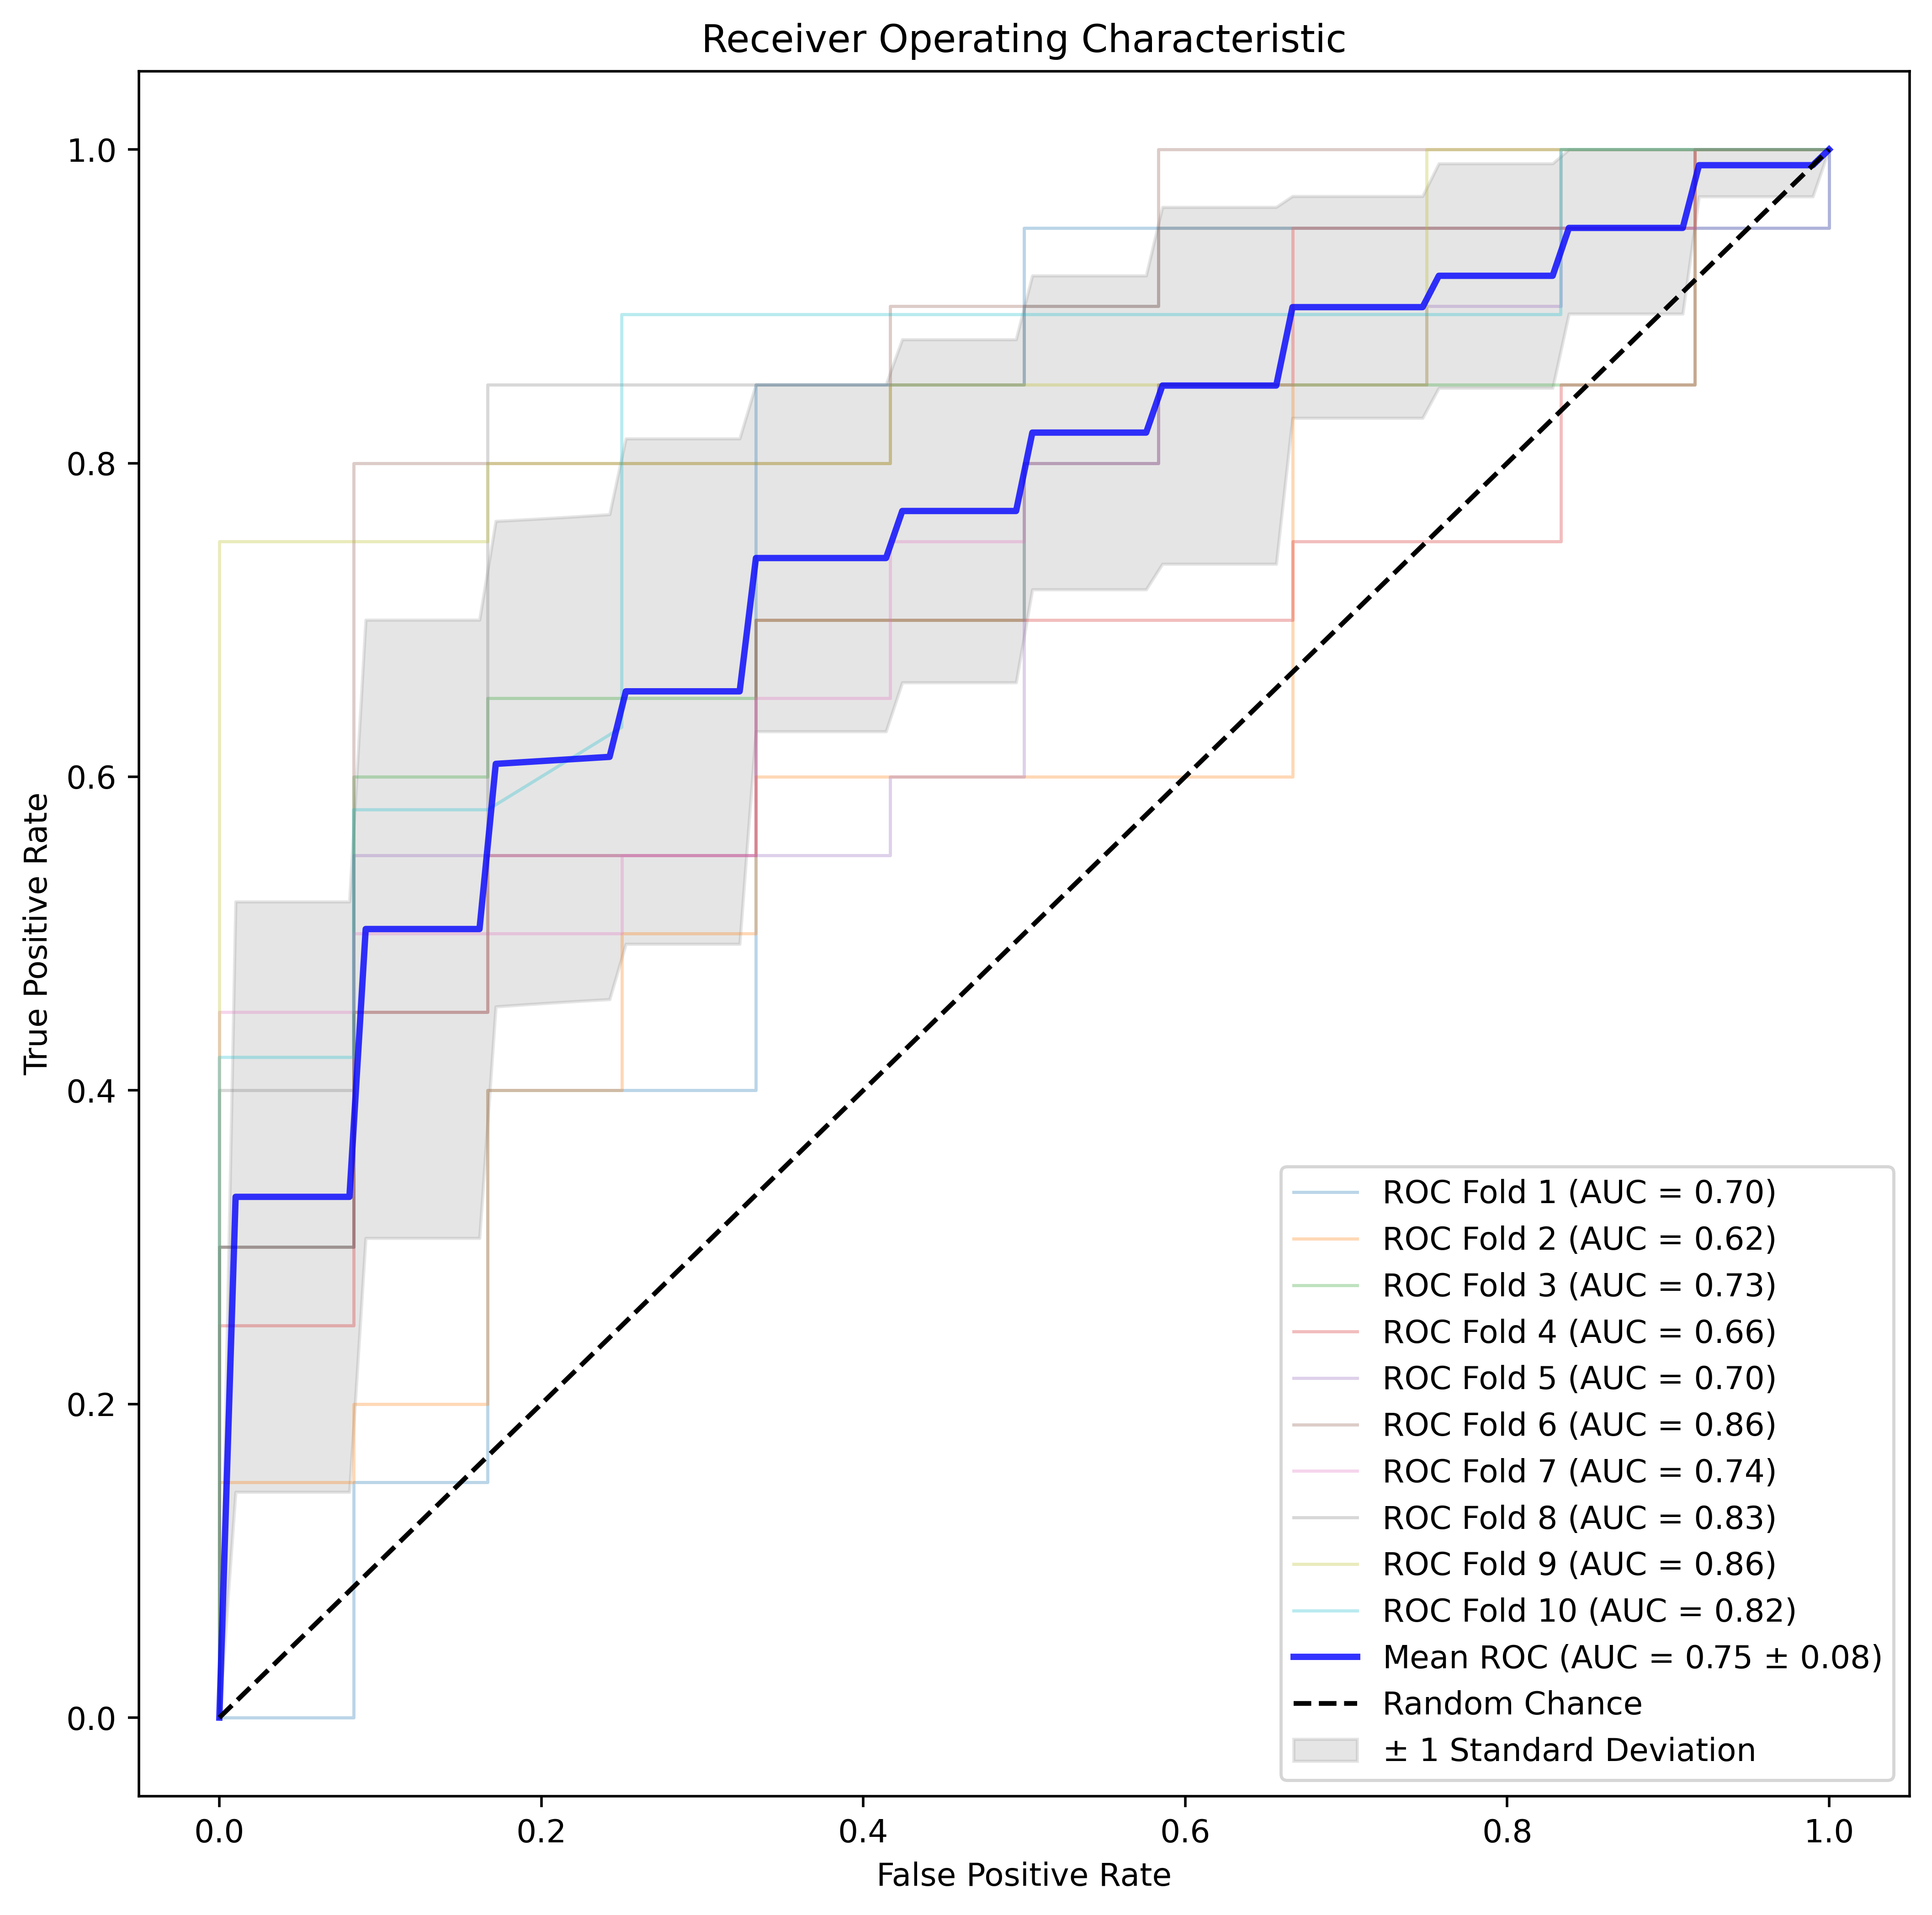

In [30]:
plot_perfomance(probas_svm_comb, y_test_svm_comb)

## Model performance

In [50]:
svm_dmri_perf = calc_performance(tp_svm_dmri, tn_svm_dmri, fp_svm_dmri, fn_svm_dmri)
dnn_dmri_perf = calc_performance(tp_dnn_dmri, tn_dnn_dmri, fp_dnn_dmri, fn_dnn_dmri)
svm_anat_perf = calc_performance(tp_svm_anat, tn_svm_anat, fp_svm_anat, fn_svm_anat)
dnn_anat_perf = calc_performance(tp_dnn_anat, tn_dnn_anat, fp_dnn_anat, fn_dnn_anat)
svm_comb_perf = calc_performance(tp_svm_comb, tn_svm_comb, fp_svm_comb, fn_svm_comb)
dnn_comb_perf = calc_performance(tp_dnn_comb, tn_dnn_comb, fp_dnn_comb, fn_dnn_comb)

In [53]:
df_perf = pd.DataFrame([svm_dmri_perf, dnn_dmri_perf, svm_anat_perf, dnn_anat_perf, svm_comb_perf, dnn_comb_perf],
                       columns=['Sensitivity', 'Specificity', 'PPV', 'NPV'],
                       index=['SVM: dMRI', 'DNN: dMRI', 'SVM: sMRI', 'DNN: sMRI', 'SVM: Combined', 'DNN: Combined'])
df_perf

Sensitivity  Specificity       PPV       NPV
SVM: dMRI         0.733668     0.625000  0.764398  0.585938
DNN: dMRI         0.728643     0.591667  0.747423  0.568000
SVM: sMRI         0.592965     0.583333  0.702381  0.463576
DNN: sMRI         0.673367     0.450000  0.670000  0.453782
SVM: Combined     0.633166     0.758333  0.812903  0.554878
DNN: Combined     0.688442     0.525000  0.706186  0.504000